## **05 MongoDB Python Aggregation**

### 0. 기본 pymongo 템플릿 코드
> sample_mflix 데이터셋을 기반으로, 지금까지 익힌 MongoDB aggregation 문법을 pymongo 에서 어떻게 적용해서 사용할 수 있는지를 알아보기로 함

In [9]:
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017')

db = client.sample_mflix  # use sample_mflix
movies = db.movies        # db.movies (collection 선택)

In [12]:
## 필드 이름 추출
movies.find_one().keys()

dict_keys(['_id', 'plot', 'genres', 'runtime', 'cast', 'num_mflix_comments', 'title', 'fullplot', 'countries', 'released', 'directors', 'rated', 'awards', 'lastupdated', 'year', 'imdb', 'type', 'tomatoes'])

### 다양한 aggregate() 문법 적용
- MongoDB aggregation 문법은 find() 가 아닌, aggregate() 메서드를 사용해야 함

**1. $match: 이 스테이지는 쿼리와 유사한 방식으로 문서를 필터링합니다.**

> 결과가 너무 많기 때문에, $limit 문법도 함께 사용하기로 함

In [13]:
###  (1)'Action' 장르의 영화 (2)한 편 출력
pipeline = [
    {"$match": {"genres" : "Action"}},
    {"$limit": 1}
]
for movie in movies.aggregate(pipeline):
    print(movie)

{'_id': ObjectId('573a1390f29313caabcd5293'), 'plot': "Young Pauline is left a lot of money when her wealthy uncle dies. However, her uncle's secretary has been named as her guardian until she marries, at which time she will officially take ...", 'genres': ['Action'], 'runtime': 199, 'cast': ['Pearl White', 'Crane Wilbur', 'Paul Panzer', 'Edward Josè'], 'num_mflix_comments': 1, 'poster': 'https://m.media-amazon.com/images/M/MV5BMzgxODk1Mzk2Ml5BMl5BanBnXkFtZTgwMDg0NzkwMjE@._V1_SY1000_SX677_AL_.jpg', 'title': 'The Perils of Pauline', 'fullplot': 'Young Pauline is left a lot of money when her wealthy uncle dies. However, her uncle\'s secretary has been named as her guardian until she marries, at which time she will officially take possession of her inheritance. Meanwhile, her "guardian" and his confederates constantly come up with schemes to get rid of Pauline so that he can get his hands on the money himself.', 'languages': ['English'], 'released': datetime.datetime(1914, 3, 23, 0, 0), '

**2. $group: 이 스테이지는 특정 필드를 기준으로 문서를 그룹화하고, 각 그룹에 대해 다양한 연산을 수행할 수 있습니다.**

In [15]:
# (1)감독별(directors) (2)영화 개수 세기
pipeline = [
    {"$group": {'_id':"$directors", "count": {'$sum': 1}}},
    {'$limit':5}
]
list(movies.aggregate(pipeline))

[{'_id': ['Auli Mantila'], 'count': 2},
 {'_id': ['Bill Krohn',
   'Myron Meisel',
   'Orson Welles',
   'Richard Wilson',
   'Norman Foster'],
  'count': 1},
 {'_id': ['Rose Bosch'], 'count': 1},
 {'_id': ['Lee Demarbre'], 'count': 1},
 {'_id': ['Peter Strickland'], 'count': 3}]

In [28]:
# 감독 그룹을 unwind하여 감독 1인 기준으로 연출한 영화의 수 계산
pipeline = [
    {'$unwind': '$directors'},
    {"$group": {'_id':"$directors", "count": {'$sum': 1}}},
    {'$sort': {"count": -1}},
    {'$limit':10}
]
list(movies.aggregate(pipeline))

[{'_id': 'Woody Allen', 'count': 40},
 {'_id': 'John Ford', 'count': 35},
 {'_id': 'Takashi Miike', 'count': 34},
 {'_id': 'John Huston', 'count': 34},
 {'_id': 'Werner Herzog', 'count': 33},
 {'_id': 'Martin Scorsese', 'count': 32},
 {'_id': 'Alfred Hitchcock', 'count': 31},
 {'_id': 'Sidney Lumet', 'count': 30},
 {'_id': 'Mario Monicelli', 'count': 29},
 {'_id': 'Michael Apted', 'count': 29}]

**3. $sort: 이 스테이지는 특정 필드를 기준으로 문서를 정렬합니다.**

In [31]:
pipeline = [
    {"$sort": {"title": 1}}, { "$limit": 5 }
]
for movie in movies.aggregate(pipeline): 
    print(movie['title'])
    
# db.movies.aggregate( [ { $sort: { title: 1 } }, 
#                                  { $limit: 3 } ] )

1
1
3
4
8


**4. $limit: 이 스테이지는 출력되는 문서의 수를 제한합니다.**

In [30]:
pipeline = [
    {"$limit": 1}
]
for movie in movies.aggregate(pipeline):
    print(movie)
    
# db.movies.aggregate( [ { $limit: 1 } ] )

{'_id': ObjectId('573a1390f29313caabcd4135'), 'plot': 'Three men hammer on an anvil and pass a bottle of beer around.', 'genres': ['Short'], 'runtime': 1, 'cast': ['Charles Kayser', 'John Ott'], 'num_mflix_comments': 1, 'title': 'Blacksmith Scene', 'fullplot': 'A stationary camera looks at a large anvil with a blacksmith behind it and one on either side. The smith in the middle draws a heated metal rod from the fire, places it on the anvil, and all three begin a rhythmic hammering. After several blows, the metal goes back in the fire. One smith pulls out a bottle of beer, and they each take a swig. Then, out comes the glowing metal and the hammering resumes.', 'countries': ['USA'], 'released': datetime.datetime(1893, 5, 9, 0, 0), 'directors': ['William K.L. Dickson'], 'rated': 'UNRATED', 'awards': {'wins': 1, 'nominations': 0, 'text': '1 win.'}, 'lastupdated': '2015-08-26 00:03:50.133000000', 'year': 1893, 'imdb': {'rating': 6.2, 'votes': 1189, 'id': 5}, 'type': 'movie', 'tomatoes': {'

**5. $project: 이 스테이지는 출력되는 문서의 필드를 추가, 제거, 또는 새로 생성합니다.**

In [33]:
pipeline=[
    {"$project": {'_id': 0, 'title':1, 'genres':1}},
    {"$limit": 100}
]

result = list(movies.aggregate(pipeline))
result

[{'genres': ['Short'], 'title': 'Blacksmith Scene'},
 {'genres': ['Short', 'Western'], 'title': 'The Great Train Robbery'},
 {'genres': ['Short', 'Drama', 'Fantasy'],
  'title': 'The Land Beyond the Sunset'},
 {'genres': ['Short', 'Drama'], 'title': 'A Corner in Wheat'},
 {'genres': ['Animation', 'Short', 'Comedy'],
  'title': 'Winsor McCay, the Famous Cartoonist of the N.Y. Herald and His Moving Comics'},
 {'genres': ['Crime', 'Drama'], 'title': 'Traffic in Souls'},
 {'genres': ['Animation', 'Short', 'Comedy'], 'title': 'Gertie the Dinosaur'},
 {'genres': ['Drama', 'History'], 'title': 'In the Land of the Head Hunters'},
 {'genres': ['Action'], 'title': 'The Perils of Pauline'},
 {'genres': ['Drama', 'History', 'Romance'], 'title': 'The Birth of a Nation'},
 {'genres': ['Drama'], 'title': 'The Cheat'},
 {'genres': ['Drama'], 'title': 'The Italian'},
 {'genres': ['Biography', 'Crime', 'Drama'], 'title': 'Regeneration'},
 {'genres': ['Action', 'Adventure', 'Crime'], 'title': 'Les vampir

In [35]:
import pandas as pd
pd.DataFrame(result)

,genres,title
0,[Short],Blacksmith Scene
1,"[Short, Western]",The Great Train Robbery
2,"[Short, Drama, Fantasy]",The Land Beyond the Sunset
3,"[Short, Drama]",A Corner in Wheat
4,"[Animation, Short, Comedy]","Winsor McCay, the Famous Cartoonist of the N.Y..."
...,...,...
95,"[Drama, History, Romance]",The Last Command
96,[Drama],"Laugh, Clown, Laugh"
97,"[Comedy, Drama, Romance]",Lonesome
98,"[Biography, Drama, History]",The Passion of Joan of Arc


**6. $unwind: 이 스테이지는 배열 필드를 풀어서 각 원소를 별도의 문서로 만듭니다.**

In [36]:
## genres를 unwind하기
pipeline = [
    {"$unwind": "$genres"},
    {"$limit": 5}
]

list(movies.aggregate(pipeline))

[{'_id': ObjectId('573a1390f29313caabcd4135'),
  'plot': 'Three men hammer on an anvil and pass a bottle of beer around.',
  'genres': 'Short',
  'runtime': 1,
  'cast': ['Charles Kayser', 'John Ott'],
  'num_mflix_comments': 1,
  'title': 'Blacksmith Scene',
  'fullplot': 'A stationary camera looks at a large anvil with a blacksmith behind it and one on either side. The smith in the middle draws a heated metal rod from the fire, places it on the anvil, and all three begin a rhythmic hammering. After several blows, the metal goes back in the fire. One smith pulls out a bottle of beer, and they each take a swig. Then, out comes the glowing metal and the hammering resumes.',
  'countries': ['USA'],
  'released': datetime.datetime(1893, 5, 9, 0, 0),
  'directors': ['William K.L. Dickson'],
  'rated': 'UNRATED',
  'awards': {'wins': 1, 'nominations': 0, 'text': '1 win.'},
  'lastupdated': '2015-08-26 00:03:50.133000000',
  'year': 1893,
  'imdb': {'rating': 6.2, 'votes': 1189, 'id': 5},
  

**7. `$group`과 `$sum`: 이 예제에서는 감독별로 영화를 그룹화하고, 각 그룹의 영화 수를 계산합니다.**

In [38]:
pipeline=[
    {"$group": {"_id": "$directors", "count" : {"$sum": 1}}},
    {"$sort": {"count":-1}},
    {"$limit": 5}
]

list(movies.aggregate(pipeline))

[{'_id': None, 'count': 265},
 {'_id': ['Woody Allen'], 'count': 39},
 {'_id': ['Takashi Miike'], 'count': 33},
 {'_id': ['Werner Herzog'], 'count': 31},
 {'_id': ['Alfred Hitchcock'], 'count': 31}]

**8. `$group`과 `$avg`: 이 예제에서는 감독별로 영화를 그룹화하고, 각 그룹의 영화 평점 평균을 계산합니다.**

In [48]:
pipeline = [
    {'$unwind': '$directors'},
    {"$group" : {'_id': "$directors", 'average_rating': {"$avg" :"$imdb.rating"}}},
    {"$sort": {"average_rating":-1}},
    {"$limit": 5}
]
# list(movies.aggregate(pipeline))
pd.DataFrame(movies.aggregate(pipeline))

,_id,average_rating
0,Sara Hirsh Bordo,9.40
1,Kevin Derek,9.30
2,Michael Benson,9.00
3,Slobodan Sijan,8.95
4,Bozidar 'Bota' Nikolic,8.90


<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 1: 컬렉션에 있는 영화의 수를 계산하세요.</font><br>
</div>

In [116]:
movie_count = movies.count_documents({})
print('총 영화의 수 :', movie_count)

총 영화의 수 : 23539


<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 2: 평균 영화 길이를 찾으세요.</font><br>
</div>

In [132]:
pipeline=[
    {"$group": {"_id": None, "avg_runtime": { "$avg": "$runtime" }}},
    {'$project': {'_id': 0, 'avg_runtime': 1}}
]

result = list(movies.aggregate(pipeline))[0]['avg_runtime']
print('평균 영화 길이:', result)

평균 영화 길이: 103.78932097696172


<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 3: 각 장르에 대한 영화 수를 계산하세요.</font><br>
</div>

In [137]:
pipeline=[
    {'$unwind': '$genres'},
    {"$group": {"_id": "$genres", "count" : {"$sum": 1}}},
]

result = list(movies.aggregate(pipeline))

<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 4: 2014년 이후에 개봉한 영화를 제목으로 정렬하여 나열하세요.</font><br>
</div>

In [139]:
documents = movies.find({'year': {'$gt': 2014}}, {'_id':0,'title':1}).sort('title',1)
list(documents)

# 연습문제 4: 2014년 이후에 출시된 영화 제목 찾기 (오름차순 정렬)
# post_2014_movies = movies.find({"year": {"$gt": 2014}}).sort("title")
# for movie in post_2014_movies:
#     print('영화 제목:', movie['title'])
    
# db.movies.find( { year: { $gt: 2014 } } ).sort( { title: 1 } )

[{'title': '(T)ERROR'},
 {'title': '11 Minutes'},
 {'title': '13 Minutes'},
 {'title': '3 1/2 Minutes, Ten Bullets'},
 {'title': '45 Years'},
 {'title': '6 Years'},
 {'title': '600 Millas'},
 {'title': '7 Chinese Brothers'},
 {'title': 'A Bigger Splash'},
 {'title': 'A Brave Heart: The Lizzie Velasquez Story'},
 {'title': 'A Country Called Home'},
 {'title': 'A Horse for Summer'},
 {'title': 'A Perfect Day'},
 {'title': 'A Sinner in Mecca'},
 {'title': 'A Sunday Kind of Love'},
 {'title': 'A Tale of Love and Darkness'},
 {'title': 'A War'},
 {'title': 'A cambio de nada'},
 {'title': 'Above and Below'},
 {'title': 'Ad Inexplorata'},
 {'title': 'Adam Curtis: Bitter Lake'},
 {'title': 'Adama'},
 {'title': 'Admiral'},
 {'title': 'Advantageous'},
 {'title': 'Aferim!'},
 {'title': 'AfterDeath'},
 {'title': 'Alias Marèa'},
 {'title': 'Alice in Earnestland'},
 {'title': 'All Eyes and Ears'},
 {'title': 'Aloha'},
 {'title': 'American Hostage'},
 {'title': 'Amy'},
 {'title': 'An'},
 {'title': 'A

<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 5: 가장 많은 영화를 제작하는 상위 5개 국가를 찾으세요.</font><br>
</div>

In [141]:
pipeline=[
    {'$unwind': '$countries'}, # 국가 array를 unwind
    {"$group": {"_id": "$countries", "count" : {"$sum": 1}}}, # 국가별 제작건수
    {'$sort': {'count': -1}}, # 내림차순 정렬
    {'$limit':5}
]
contries = list(movies.aggregate(pipeline))
pd.DataFrame(contries)

,_id,count
0,USA,11855
1,France,3093
2,UK,2904
3,Germany,1659
4,Italy,1388


<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 6: 2000년 이후 영화의 연도별 평균 IMDB 평점을 찾으세요.</font><br>
</div>

In [144]:
pipeline=[
    {'$match' : { 'year': { '$gte': 2000 } }},
    {"$group": {"_id": "$year", "averagerating" : {"$avg": '$imdb.rating'}}},
    {'$sort': {'_id':-1}}
]
df_rating = pd.DataFrame(list(movies.aggregate(pipeline)))

<Axes: xlabel='_id'>

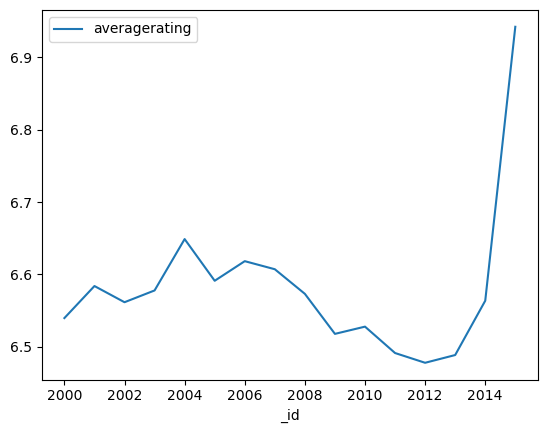

In [145]:
df_rating.set_index('_id').plot()

<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 7:  'Star'라는 단어가 포함된 영화의 제목을 가져오세요.</font><br>
</div>

In [149]:
list(movies.find({"title": {'$regex' : '.*Star.*'}},{'_id':0,'title':1}))

[{'title': 'A Star Is Born'},
 {'title': 'The Stars Look Down'},
 {'title': 'A Star Is Born'},
 {'title': 'The Tin Star'},
 {'title': 'It Started with a Kiss'},
 {'title': 'Stars'},
 {'title': 'It Started in Naples'},
 {'title': 'It Is Written in the Stars, Inspector Palmu'},
 {'title': 'Dog Star Man: Part IV'},
 {'title': 'Star!'},
 {'title': 'Start the Revolution Without Me'},
 {'title': 'Dark Star'},
 {'title': 'Stardust'},
 {'title': 'The Bingo Long Traveling All-Stars & Motor Kings'},
 {'title': 'A Star Is Born'},
 {'title': 'Star Wars: Episode IV - A New Hope'},
 {'title': 'Starcrash'},
 {'title': 'Starting Over'},
 {'title': 'Star Trek: The Motion Picture'},
 {'title': 'Battle Beyond the Stars'},
 {'title': 'Star Wars: Episode V - The Empire Strikes Back'},
 {'title': "I'm Starting from Three"},
 {'title': 'Stardust Memories'},
 {'title': 'The Night of the Shooting Stars'},
 {'title': 'Star Trek II: The Wrath of Khan'},
 {'title': 'Starstruck'},
 {'title': 'Star Wars: Episode VI

<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 8:  데이터셋에서 사용 가능한 모든 고유 언어를 나열하세요.</font><br>
</div>

In [151]:
distinct_languages = movies.distinct("languages")
# print('사용 가능한 언어:', ', '.join(distinct_languages))
distinct_languages

[' Ancient (to 1453)',
 ' Old',
 'Abkhazian',
 'Aboriginal',
 'Acholi',
 'Afrikaans',
 'Aidoukrou',
 'Albanian',
 'Algonquin',
 'American Sign Language',
 'Amharic',
 'Apache languages',
 'Arabic',
 'Aramaic',
 'Arapaho',
 'Armenian',
 'Assamese',
 'Assyrian Neo-Aramaic',
 'Athapascan languages',
 'Awadhi',
 'Aymara',
 'Azerbaijani',
 'Balinese',
 'Bambara',
 'Basque',
 'Belarusian',
 'Bengali',
 'Berber languages',
 'Bhojpuri',
 'Bosnian',
 'Brazilian Sign Language',
 'Breton',
 'British Sign Language',
 'Bulgarian',
 'Burmese',
 'Cantonese',
 'Catalan',
 'Chechen',
 'Cheyenne',
 'Chinese',
 'Cornish',
 'Corsican',
 'Cree',
 'Creole',
 'Creoles and pidgins',
 'Croatian',
 'Crow',
 'Czech',
 'Danish',
 'Dari',
 'Dinka',
 'Dutch',
 'Dyula',
 'Dzongkha',
 'Eastern Frisian',
 'Egyptian (Ancient)',
 'English',
 'Esperanto',
 'Estonian',
 'Ewe',
 'Faroese',
 'Filipino',
 'Finnish',
 'Flemish',
 'French',
 'French Sign Language',
 'Frisian',
 'Fulah',
 'Fur',
 'Gallegan',
 'Georgian',
 'Germ

<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 9:  각각의 감독이 제작한 영화 수가 25개 이상인 감독들을 찾으세요.</font><br>
</div>

In [101]:
pipeline = [
    {'$unwind': '$directors'},
    {"$group": {"_id": "$directors", "count": {"$sum": 1}}},
    {'$match': {'count': {'$gte': 25}}},
    {'$sort': {'count': -1}},
    {'$project': {'_id': 1}}
]

list(movies.aggregate(pipeline))

[{'_id': 'Woody Allen'},
 {'_id': 'John Ford'},
 {'_id': 'Takashi Miike'},
 {'_id': 'John Huston'},
 {'_id': 'Werner Herzog'},
 {'_id': 'Martin Scorsese'},
 {'_id': 'Alfred Hitchcock'},
 {'_id': 'Sidney Lumet'},
 {'_id': 'Michael Apted'},
 {'_id': 'Mario Monicelli'},
 {'_id': 'George Cukor'},
 {'_id': 'Steven Spielberg'},
 {'_id': 'Robert Altman'},
 {'_id': 'Spike Lee'},
 {'_id': 'Steven Soderbergh'},
 {'_id': 'Ken Loach'},
 {'_id': 'Johnnie To'},
 {'_id': 'Clint Eastwood'},
 {'_id': 'Jean-Luc Godard'},
 {'_id': 'Wim Wenders'},
 {'_id': 'William Wyler'},
 {'_id': 'Michael Winterbottom'},
 {'_id': 'Ridley Scott'},
 {'_id': 'Ingmar Bergman'}]

<div class="alert alert-block" style="border: 2px solid #1565C0;background-color:#E3F2FD;padding:10px">
<font size="3em" style="color:#0D47A1;">연습문제 10:  관람객 평점을 기준으로 상위 5개의 영화를 찾으세요 (1000표 이상의 영화에 한함).</font><br>
</div>

In [115]:
pipeline = [
    {'$match': { 'imdb.votes': { '$gte': 1000 } }},
    {'$sort': { 'imdb.rating': -1 }},
    {'$limit': 5 },
    {'$project': {'_id': 0, 'title': 1}}
]

list(movies.aggregate(pipeline))

[{'title': 'Band of Brothers'},
 {'title': 'Planet Earth'},
 {'title': 'The Civil War'},
 {'title': 'The Civil War'},
 {'title': 'The Shawshank Redemption'}]